# Tikhonov regularisation

Solve

$$\min_{u,\alpha,\beta} \alpha \|Ku - f^\delta\|_2^2 + \beta \|Lu\|_2^2 - n\log\alpha - n\log\beta,$$

with a given forward opertor $K \in \mathbb{R}^{n\times n}$ and noise measurements

$$f^\delta = K\overline{u} + \epsilon,$$

where $\epsilon \sim N(0,\sigma^2I)$.

This allows a closed-form solution in terms of $u$:

$$\widehat{u}(\alpha,\beta) = \left(K^*\!K + (\beta/\alpha)L^*\!L\right)^{-1}K^*\!f^\delta.$$

Then, solve for $(\widehat\alpha,\widehat\beta)$ as

$$\min_{\alpha,\beta} \alpha \|K\widehat{u}(\alpha,\beta) - f^\delta\|_2^2 + \beta \|L\widehat{u}(\alpha,\beta)\|_2^2 - n\log\alpha - n\log\beta.$$

We conjecture that in expectation over the noise we have

$$\mathbb{E}\|K\widehat{u}(\widehat\alpha,\widehat\beta) - f^\delta\|_2^2 = n\sigma^2,$$

and

$$\lim_{\sigma\rightarrow 0} \widehat\beta/\widehat\alpha = 0.$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive, FloatLogSlider
from scipy.optimize import minimize, minimize_scalar, root_scalar
from scipy.sparse import dia_matrix
#from pyunlocbox import functions, solvers

In [2]:
def getK(x):
    h = x[1] - x[0]
    xx,yy = np.meshgrid(x,x)
    K = h/(1 + (xx - yy)**2)**(3/2)

    return K

def getL(x):
    h = x[1] - x[0]
    n = len(x)
    ex = np.ones(n)
    data = np.array([ex, -2 * ex, ex])
    offsets = np.array([-1, 0, 1])
    L = (1/h**2)*dia_matrix((data, offsets), shape=(n, n)).toarray()
    
    return L

def plot_result(x,u_bar,u_hat,f_delta,fname=''):
    # predicted data
    f_hat = K@u_hat

    # plot ground truth and data
    fig, axs = plt.subplots(1,2)

    axs[0].plot(x,u_bar,label='ground truth')
    axs[0].plot(x,u_hat,label='regularised solution')
    axs[0].set_xlabel(r'$x$')
    axs[0].set_ylabel(r'$u(x)$')
    axs[0].legend()

    axs[1].plot(x,f_delta,label='noisy data')
    axs[1].plot(x,f_hat,label='prediction')
    axs[1].set_xlabel(r'$x$')
    axs[1].set_ylabel(r'$f(x)$')
    axs[1].legend()

    fig.set_figwidth(10)
    fig.tight_layout()
    if fname:
        fig.savefig(fname,dpi=300)
    plt.show()
    
def objective(u,theta,f_delta,K,L):
    m,n = K.shape
    if len(u) and len(theta):
        alpha,beta = theta
        val  = alpha*np.linalg.norm(K@u - f_delta)**2 + beta*np.linalg.norm(L@u)**2 - m*np.log(alpha) - n*np.log(beta)
        grad = 2*alpha*K.T@(K@u - f_delta) + 2*beta*L.T@(L@u)
        sol  = []
    elif len(u):
        alpha = m/np.linalg.norm(K@u - f_delta)**2
        beta  = n/np.linalg.norm(L@u)**2
        val   = m + n - m*np.log(alpha) - n*np.log(beta)
        grad  = 2*alpha*K.T@(K@u - f_delta) + 2*beta*L.T@(L@u)
        sol   = (alpha,beta)
    elif len(theta):
        alpha,beta = theta                     
        u     = solve(K,L,f_delta,beta/alpha)
        val   = alpha*np.linalg.norm(K@u - f_delta)**2 + beta*np.linalg.norm(L@u)**2 - m*np.log(alpha) - n*np.log(beta)
        grad  = 2*alpha*K.T@(K@u - f_delta) + 2*beta*L.T@(L@u)
        sol   = u
    return val, grad, sol

                        
def solve(K,L,f_delta,lmbda):
    return np.linalg.solve(K.T@K + lmbda*L.T@L, K.T@f_delta)

def getLcurve(K,L,f_delta,lmbda):
    nl = len(lmbda)
    res = np.zeros(nl)
    reg = np.zeros(nl)
    for i in range(nl):
        u_hat = solve(K,L,f_delta,lmbda[l])
        res[l] = np.linalg.norm(K@u_hat - f_delta)
        reg[l] = np.linalg.norm(L@u_hat)
    return res,reg    
    
def estimate_parameters(K,L,f_delta,verbose=False):
    # estimate parameters
    obj = lambda theta : getObj(K,L,f_delta,theta[0],theta[1])

    alpha_init = 1/sigma**2
    beta_init = n/np.linalg.norm(L@u_bar)**2

    result = minimize(obj, [alpha_init,beta_init],method='Nelder-Mead')
    if verbose:
        print(result)
    alpha_hat,beta_hat = result.x
    
    return alpha_hat,beta_hat


## Example -- gravity surveying

In [3]:
# parameters
n = 200
m = 200
sigma = 1e-3

# grid
h = 1/n
x = np.linspace(h/2,1-h/2,n)

# operators
K = getK(x)
L = getL(x)

# ground truth
u_bar = x*(1-x)
f_bar = K@u_bar

# noisy data
f_delta = f_bar + sigma*np.random.randn(n)

## Solution as function of $\lambda$

In [4]:
# visualise solutions
plot_solution = lambda l : plot_result(x,u_bar,solve(K,L,f_delta,l),f_delta)

interactive_plot = interactive(plot_solution, l=FloatLogSlider(min=-16, max=0, step=.1,value=1e-6, description=r'$\lambda$'), continuous_update=False)
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatLogSlider(value=1e-06, description='$\\lambda$', max=0.0, min=-16.0), Output(layout…

## L-curve

## Parameter estimation I

In [16]:
%%time
# estimate parameters
theta_init = [1/sigma**2, n/np.linalg.norm(L@u_bar)**2]

fh = lambda theta : objective([],theta,f_delta,K,L)[0]
result = minimize(fh, theta_init,method='Nelder-Mead')
print(result)

alpha_hat,beta_hat = result.x
lmbda_hat = beta_hat/alpha_hat
print(lmbda_hat)

 final_simplex: (array([[1.03149176e+06, 3.07290658e-01],
       [1.03149176e+06, 3.07290658e-01],
       [1.03149176e+06, 3.07290658e-01]]), array([-2133.31106599, -2133.31106599, -2133.31106599]))
           fun: -2133.311065992588
       message: 'Optimization terminated successfully.'
          nfev: 167
           nit: 82
        status: 0
       success: True
             x: array([1.03149176e+06, 3.07290658e-01])
2.979089796480612e-07
CPU times: user 880 ms, sys: 656 ms, total: 1.54 s
Wall time: 298 ms


In [6]:
ns = 20
fh = lambda theta : objective([],theta,f_delta,K,L)[0]
alphas = np.logspace(5,7,ns)
betas = np.logspace(-2,0,ns)

vals = np.zeros((ns,ns))
for i in range(ns):
    for j in range(ns):
        vals[i,j] = fh([alphas[i],betas[j]])

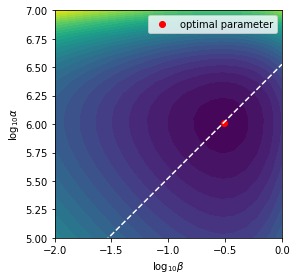

In [7]:
fig, axs = plt.subplots(1,1)

axs.contourf(np.log10(betas),np.log10(alphas),vals,levels=30)
axs.set_xlabel(r'$\log_{10} \beta$')
axs.set_ylabel(r'$\log_{10} \alpha$')
axs.plot(np.log10(beta_hat),np.log10(alpha_hat),'ro',label='optimal parameter')
axs.plot(np.log10(betas),np.log10(alpha_hat*(betas/beta_hat)),'w--')
axs.set_xlim(np.log10(betas[0]),np.log10(betas[-1]))
axs.set_ylim(np.log10(alphas[0]),np.log10(alphas[-1]))
axs.set_aspect(1)
axs.legend()

#fig.set_figwidth(10)
fig.tight_layout()
fig.savefig('Tikh_theta_hat.png',dpi=300)

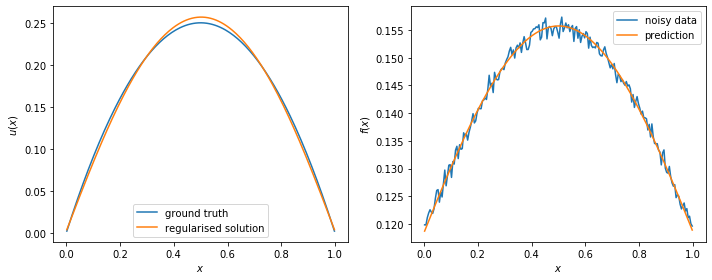

In [8]:
u_hat = solve(K,L,f_delta,lmbda_hat)
plot_result(x,u_bar,u_hat,f_delta,fname='Tikh_u_hat.png')


## Parameter estimation II

In [15]:
%%time
fh = lambda u : objective(u,[],f_delta,K,L)[0]
gh = lambda u : objective(u,[],f_delta,K,L)[1]

u0 = np.random.randn(n)
result = minimize(fh, u0, method='BFGS', jac=gh, tol=1e-3, options={'maxiter':500})
u_hat = result.x
alpha_hat = m/np.linalg.norm(K@u_hat - f_delta)**2
beta_hat = n/np.linalg.norm(L@u_hat)**2

print(alpha_hat,beta_hat,beta_hat/alpha_hat)

1029980.697340394 0.29001511957684595 2.8157335406937246e-07
CPU times: user 1.99 s, sys: 366 ms, total: 2.36 s
Wall time: 414 ms


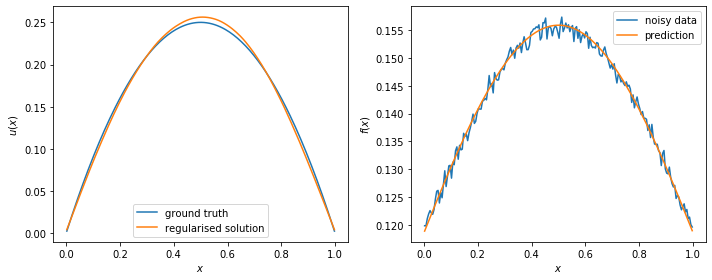

In [10]:
plot_result(x,u_bar,u_hat,f_delta,fname='Tikh_u_hat.png')


In [11]:
ns = 20
fh = lambda theta : objective([],theta,f_delta,K,L)[0]
alphas = np.logspace(5,7,ns)
betas = np.logspace(-2,0,ns)

vals = np.zeros((ns,ns))
for i in range(ns):
    for j in range(ns):
        vals[i,j] = fh([alphas[i],betas[j]])

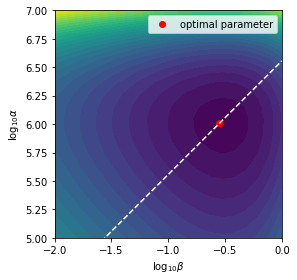

In [12]:
fig, axs = plt.subplots(1,1)

axs.contourf(np.log10(betas),np.log10(alphas),vals,levels=30)
axs.set_xlabel(r'$\log_{10} \beta$')
axs.set_ylabel(r'$\log_{10} \alpha$')
axs.plot(np.log10(beta_hat),np.log10(alpha_hat),'ro',label='optimal parameter')
axs.plot(np.log10(betas),np.log10(alpha_hat*(betas/beta_hat)),'w--')
axs.set_xlim(np.log10(betas[0]),np.log10(betas[-1]))
axs.set_ylim(np.log10(alphas[0]),np.log10(alphas[-1]))
axs.set_aspect(1)
axs.legend()

#fig.set_figwidth(10)
fig.tight_layout()
fig.savefig('Tikh_theta_hat.png',dpi=300)

## Consistency and convergence

In [13]:
def map_estimate(f_delta):
    theta_init = [1/sigma**2, n/np.linalg.norm(L@u_bar)**2]

    fh = lambda theta : objective([],theta,f_delta,K,L)[0]
    result = minimize(fh, theta_init,method='Nelder-Mead')
    
    alpha_hat,beta_hat = result.x
    lmbda_hat = beta_hat/alpha_hat
    
    u_hat = solve(K,L,f_delta,lmbda_hat)
    
    return u_hat,lmbda_hat

ns = 10
na = 10
sigmas = np.logspace(-10,-3,ns)

lmbds_map = np.zeros((ns,na))
errors = np.zeros((ns,na))
residuals = np.zeros((ns,na))
for i in range(ns):
    for j in range(na):
        fij = f_bar + sigmas[i]*np.random.randn(n)
        
        u_hat,lmbda_hat = map_estimate(fij)
        
        lmbds_map[i,j] = lmbda_hat
        errors[i,j] = np.linalg.norm(u_bar-u_hat)
        residuals[i,j] = np.linalg.norm(K@u_hat - fij)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in log


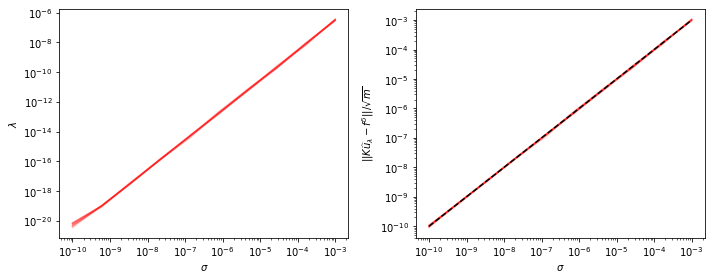

In [14]:
fig,axs = plt.subplots(1,2)

axs[0].loglog(sigmas,lmbds_map,'r-',alpha=.2)
axs[0].set_xlabel(r'$\sigma$')
axs[0].set_ylabel(r'$\lambda$')

axs[1].loglog(sigmas,residuals/np.sqrt(m),'r-',alpha=0.2)
axs[1].loglog(sigmas,sigmas,'k--')
axs[1].set_xlabel(r'$\sigma$')
axs[1].set_ylabel(r'$||K\widehat{u}_\lambda - f^\delta||/\sqrt{m}$')

fig.set_figwidth(10)
fig.tight_layout()
fig.savefig('Tikh_convergence.png',dpi=300)